![image.png](https://i.imgur.com/a3uAqnb.png)

# **🌊 Flood Area Segmentation with U-Net (Pretrained Encoder)**  
In this lab, we will:

✅ **Build a custom Dataset class** for flood segmentation  
✅ **Use `segmentation_models_pytorch (SMP)`** to load **U-Net** with a **pretrained encoder**  
✅ Train the model and evaluate its performance

In [ ]:
# # Please uncomment this out when you are running this lab on google colab!
# import os

# # Set KaggleHub cache to a directory inside /content/
# os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

print("Path to dataset files:", path)

100%|██████████| 107M/107M [00:00<00:00, 215MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


## **1️⃣ Dataset Class**

- The dataset consists of:
- **Images:** RGB flood images (`.jpg`)
- **Masks:** Corresponding segmentation masks (`.png`)
- **Metadata:** A CSV file (`metadata.csv`) mapping images to masks.
- The masks highlight the **water regions** in the images.
- We will create a **custom PyTorch Dataset class** to load images and masks.





In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
# Custom Dataset Class
class FloodSegmentationDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None, target_transform=None): # target  is mask
        self.root_dir = root_dir
        self.metadata = pd.read_csv(csv_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, "Image", self.metadata.iloc[idx, 0])   # Use the csv to get paths
        mask_path = os.path.join(self.root_dir, "Mask", self.metadata.iloc[idx, 1])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale (1 channel = binary segmentation)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask       # In image classification datasets, we return image and label. Here, we return image and mask

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define transforms for images and masks
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # جاو من Standard ImageNet normalization
])

mask_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)  # Keep segmentation masks intact
    # interpolation  مثل nearset neighber يكرر العدد بناء عل نيرست بيكسل
])

In [ ]:
## **🔹 Splitting the Dataset into Train & Test**

# Define dataset paths
csv_path = os.path.join(path, "metadata.csv")

# Read metadata CSV
metadata = pd.read_csv(csv_path)

# Split dataset into 80% train, 20% test
train_data, test_data = train_test_split(metadata, test_size=0.2, random_state=42, shuffle=True)

# Save split CSVs
train_data.to_csv(os.path.join(path, "train.csv"), index=False)
test_data.to_csv(os.path.join(path, "test.csv"), index=False)

In [ ]:
# Load training dataset
train_dataset = FloodSegmentationDataset(root_dir=path, csv_file=os.path.join(path, "train.csv"),
                                         transform=image_transforms, target_transform=mask_transforms)

# Load testing dataset
test_dataset = FloodSegmentationDataset(root_dir=path, csv_file=os.path.join(path, "test.csv"),
                                        transform=image_transforms, target_transform=mask_transforms)


# Create Train & Test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Check dataset sizes
print(f"Training Samples: {len(train_dataset)}, Testing Samples: {len(test_dataset)}")


Training Samples: 232, Testing Samples: 58


### Let's display some images

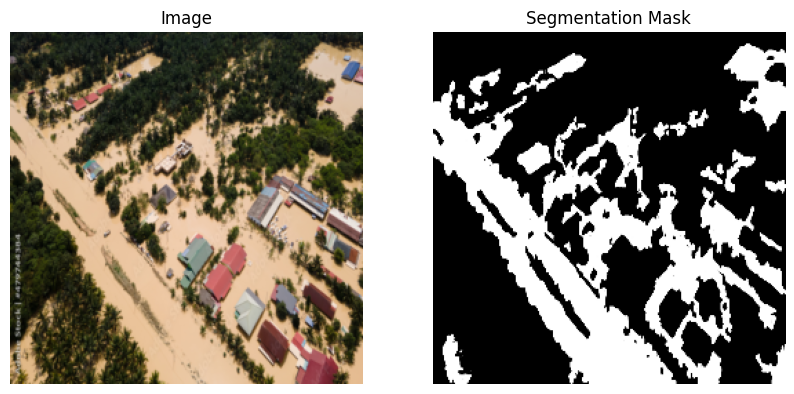

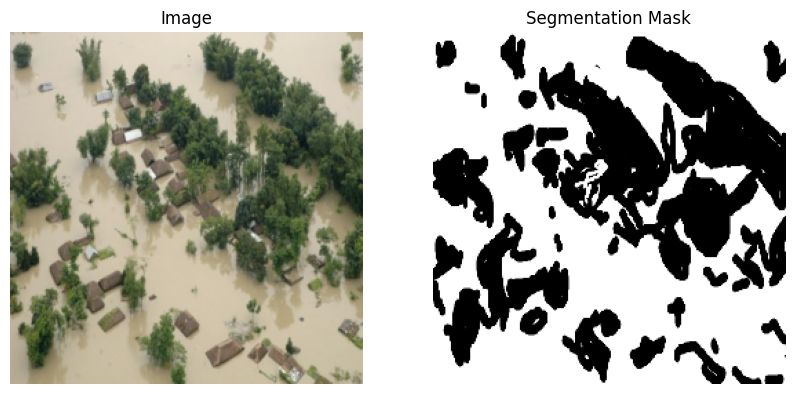

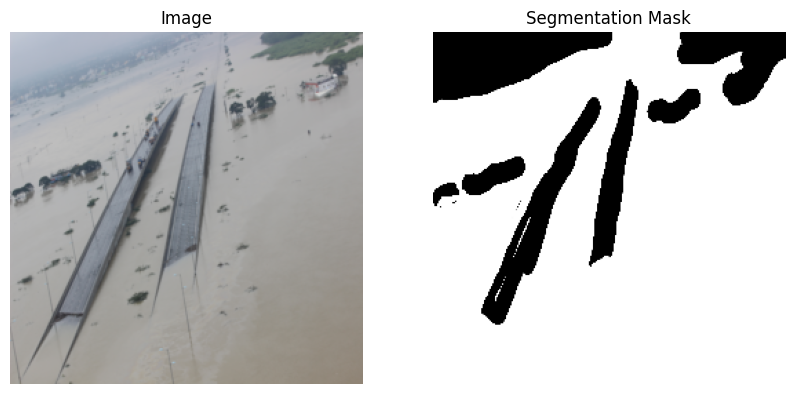

In [ ]:
import matplotlib.pyplot as plt

# Function to denormalize images (We cannot show normalized images. We have to reverse normalizaion first.)
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img

# Display some images with their masks
for i in range(3):
    img, mask = train_dataset[i]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(denormalize(img))
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")
    plt.show()


## **2️⃣ Model Class**

- We use **U-Net** from the **`segmentation_models_pytorch (SMP)`** library.
- The encoder (backbone) is **pretrained EfficientNet-B0** for better feature extraction.
- The decoder is **randomly initialized** and trained for segmentation.
- **Binary segmentation output (1 class for flood area)**  
- **Sigmoid activation** to output probability maps  
- **Binary Cross Entropy (BCE) Loss**  

![image.png](https://i.imgur.com/UVgm5kz.png)

In [ ]:
!pip install -q segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import segmentation_models_pytorch as smp

# Define U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="efficientnet-b0",  # Pretrained encoder (backbone)
    encoder_weights="imagenet",  # Use ImageNet weights
    in_channels=3,  # RGB images
    classes=1,  # Binary segmentation (1 output channel)
    activation="sigmoid"  # Apply Sigmoid activation directly in the model
).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 142MB/s] 


## **3️⃣ Training and Validation Loops**

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader) # avg

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

## **4️⃣ Running Training**
- We fine-tune the **pretrained U-Net model** on our flood segmentation dataset.
- We train the model using **Binary Cross Entropy (BCE) Loss**.

In [ ]:
import torch
from torch import nn
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 10  # Define number of epochs
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 58/58 [01:54<00:00,  1.98s/it]


Epoch 1/10: Train Loss = 0.6913, Val Loss = 0.5236


100%|██████████| 58/58 [01:44<00:00,  1.80s/it]


Epoch 2/10: Train Loss = 0.4731, Val Loss = 0.3733


100%|██████████| 58/58 [01:42<00:00,  1.76s/it]


Epoch 3/10: Train Loss = 0.3735, Val Loss = 0.3347


100%|██████████| 58/58 [01:42<00:00,  1.76s/it]


Epoch 4/10: Train Loss = 0.3266, Val Loss = 0.2950


100%|██████████| 58/58 [01:47<00:00,  1.85s/it]


Epoch 5/10: Train Loss = 0.2936, Val Loss = 0.2781


100%|██████████| 58/58 [01:44<00:00,  1.81s/it]


Epoch 6/10: Train Loss = 0.2712, Val Loss = 0.2642


100%|██████████| 58/58 [01:43<00:00,  1.78s/it]


Epoch 7/10: Train Loss = 0.2528, Val Loss = 0.2506


100%|██████████| 58/58 [01:43<00:00,  1.78s/it]


Epoch 8/10: Train Loss = 0.2393, Val Loss = 0.2493


100%|██████████| 58/58 [01:43<00:00,  1.78s/it]


Epoch 9/10: Train Loss = 0.2240, Val Loss = 0.2435


100%|██████████| 58/58 [01:45<00:00,  1.82s/it]


Epoch 10/10: Train Loss = 0.2027, Val Loss = 0.2488


### **🔹 Plot Training Loss Curve**


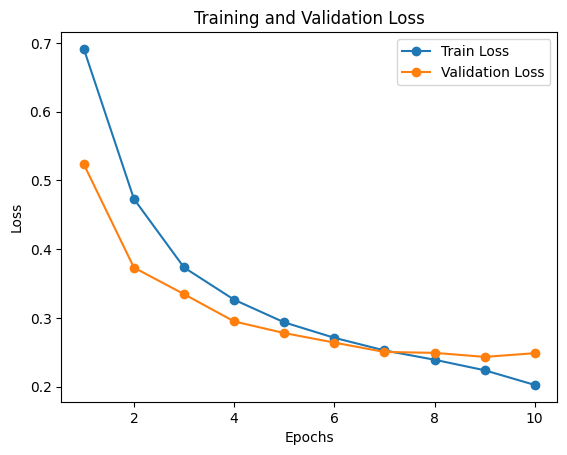

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## **5️⃣ Visualizing Predictions**

- We compare **predicted flood masks** against **ground truth masks**.
- We visualize results for multiple test images.

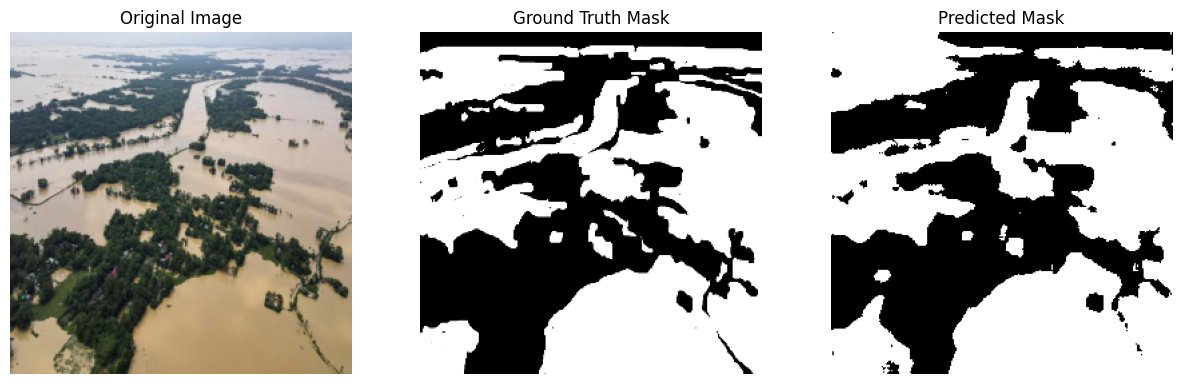

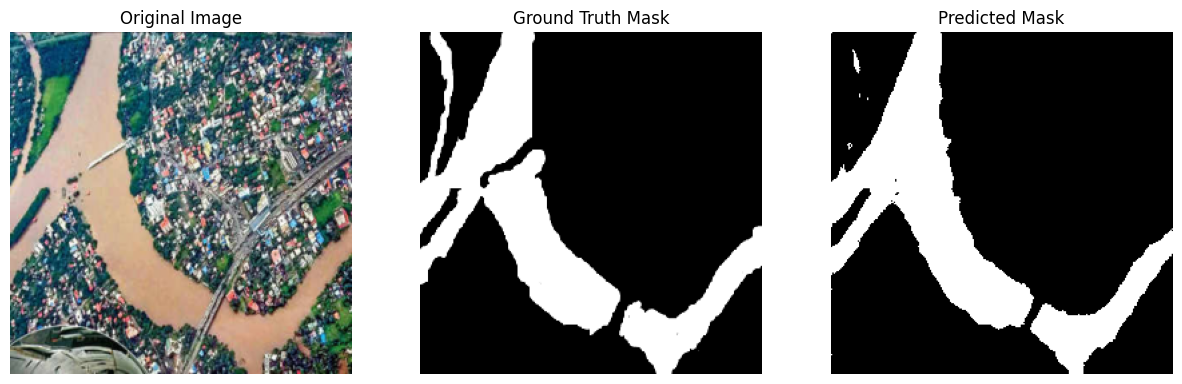

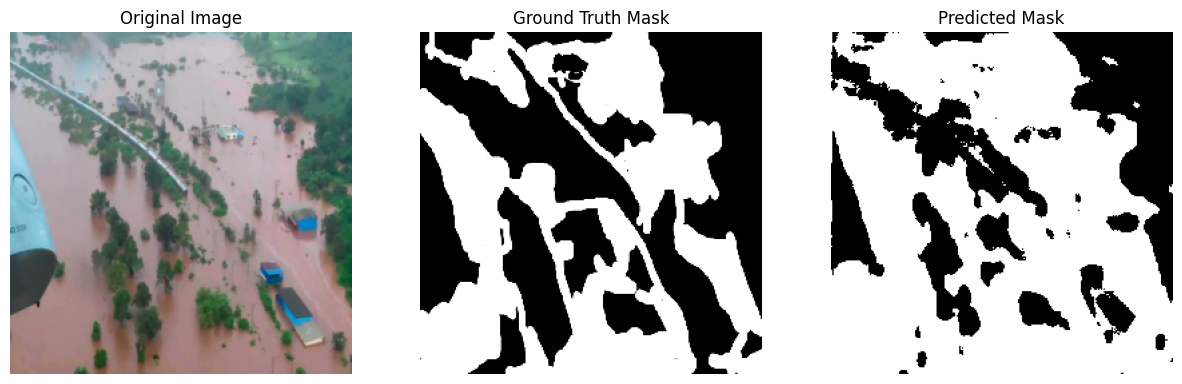

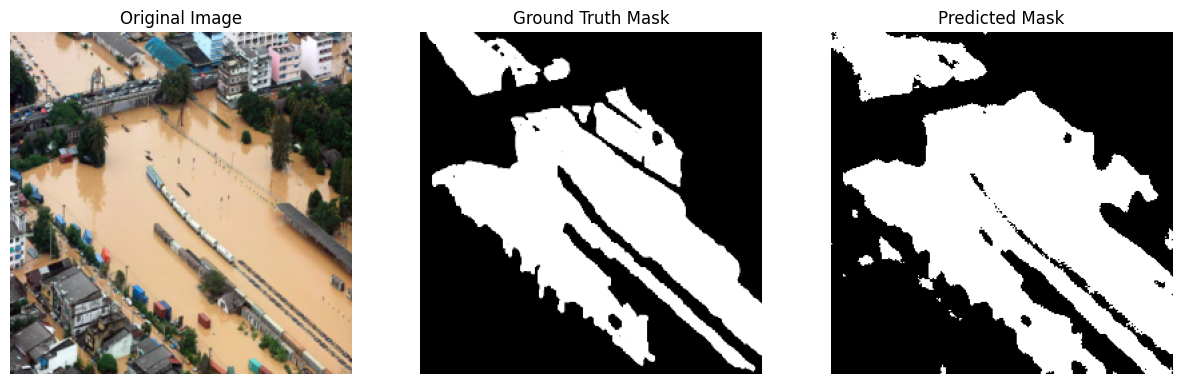

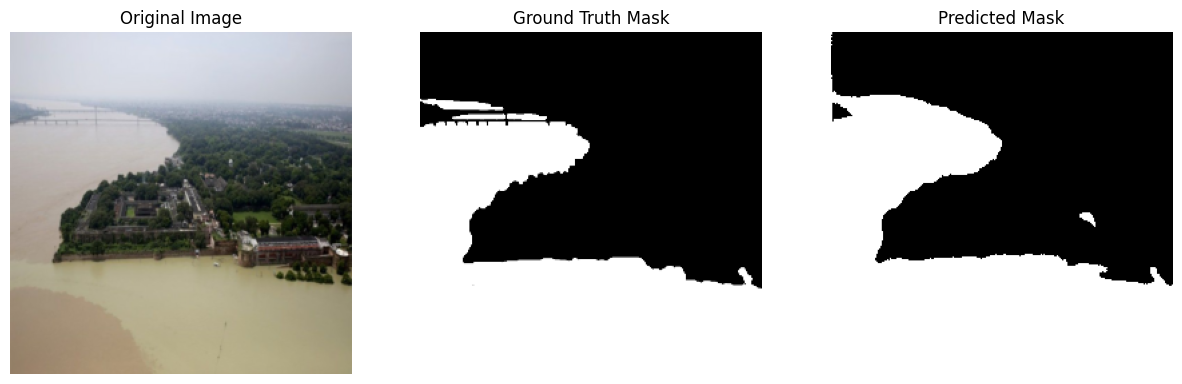

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize images
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img

# Set model to evaluation mode
model.eval()

# Get some test samples
test_samples = random.sample(range(len(test_dataset)), 5)

for idx in test_samples:
    img, mask = test_dataset[idx]

    with torch.no_grad():
        pred_mask = model(img.unsqueeze(0).to(device))  # Forward pass

    pred_mask = (pred_mask >= 0.5).cpu().squeeze().numpy()  # Convert to binary mask

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image (Denormalized)
    axes[0].imshow(denormalize(img))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Ground Truth Mask
    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Predicted Mask
    axes[2].imshow(pred_mask, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()


### Contributed by: Mohamed Eltayeb